In [6]:
import pandas as pd
import numpy as np
from collections import Counter
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import ast
import pickle

In [7]:
main_df = pd.read_csv("../data/animes_better.csv")
columns_to_drop = ['title', 'aired', 'episodes', 'members', 'ranked', 'score', 'link', 'img_url']
main_df = main_df.drop(columns=columns_to_drop)
main_df

,uid,synopsis,genre,popularity,Type,Producers,Studios,Source,Themes,Demographic,Duration,Favorites,Streaming Platforms
0,28891,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",141,TV,"['Dentsu', 'Mainichi Broadcasting System', 'Mo...",['Production I.G'],Manga,"['School', 'Team Sports']",Shounen,24.0,15764,['Crunchyroll']
1,23273,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",28,TV,"['Aniplex', 'Dentsu', 'Kodansha', 'Fuji TV', '...",['A-1 Pictures'],Manga,"['Love Polygon', 'Music', 'School']",Shounen,22.0,86357,"['Crunchyroll', 'Netflix']"
2,34599,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",98,TV,"['AT-X', 'Takeshobo', 'Sony Music Communicatio...",['Kinema Citrus'],Web manga,['Theme Unknown'],Demographic Unknown,25.0,44597,"['Crunchyroll', 'HIDIVE', 'Netflix']"
3,5114,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",4,TV,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...",['Bones'],Manga,['Theme Unknown'],Shounen,24.0,227331,['Crunchyroll']
4,31758,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",502,Movie,"['Aniplex', 'Kodansha']",['Shaft'],Light novel,['Theme Unknown'],Demographic Unknown,83.0,7588,['No Streaming Platform']
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,10075,All-new animation offered throughout UNIQLO cl...,"['Action', 'Comedy', 'Super Power', 'Martial A...",2382,OVA,['Producer Unknown'],['Pierrot'],Manga,['Theme Unknown'],Shounen,6.0,85,['No Streaming Platform']
16212,35828,High school student Sora Kashiwagi is accustom...,"['Slice of Life', 'Comedy', 'Supernatural']",1648,TV,"['TBS', 'Grooove', 'Nichion', 'Exit Tunes', 'O...",['8bit'],Web manga,"['Mythology', 'Pets', 'School']",Demographic Unknown,24.0,753,['Crunchyroll']
16213,10378,"After regaining her squid-like abilities, Ika ...","['Slice of Life', 'Comedy', 'Shounen']",1547,TV,"['TV Tokyo', 'Lantis', 'Pony Canyon', 'TV Toky...",['Diomedéa'],Manga,['Anthropomorphic'],Shounen,24.0,178,"['Crunchyroll', 'HIDIVE']"
16214,33082,"For years, the Niflheim Empire and the kingdom...",['Action'],2154,Movie,['Square Enix'],['Square Enix Visual Works'],Game,['Theme Unknown'],Demographic Unknown,115.0,154,['No Streaming Platform']


In [8]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

def encode_multilabel_predictor(df, predictor):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[predictor])
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    return encoded_df, mlb.classes_

In [9]:
filtered_df = main_df[
    (main_df['Producers'] != "['Producer Unknown']") & 
    (main_df['Producers'] != "['']") &
    (main_df['Type'] != "Type Unknown") &
    (main_df['Source'] != "Source Unknown") &
    (main_df['Demographic'] != "Demographic Unknown")
].copy()

filtered_df.loc[:, 'Producers'] = filtered_df['Producers'].apply(safe_literal_eval)
all_producers = [producer for sublist in filtered_df['Producers'] for producer in sublist]
producer_counts = Counter(all_producers)
filtered_df.loc[:, 'Producer_Count'] = filtered_df['Producers'].apply(lambda x: sum([producer_counts[producer] for producer in x]))

encoded_genre_df, genre_classes = encode_multilabel_predictor(filtered_df, 'genre')

additional_features = ['Producer_Count', 'popularity']
if 'Platform_Count' in filtered_df.columns:
    additional_features.append('Platform_Count')

encoded_df = pd.concat([encoded_genre_df, filtered_df[additional_features]], axis=1)

categorical_features = ['Type', 'Source', 'Demographic']
for feature in categorical_features:
    if sklearn.__version__ >= '0.23':
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    else:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_feature = encoder.fit_transform(filtered_df[feature].values.reshape(-1, 1))
    feature_names = encoder.get_feature_names_out([feature])
    encoded_df = pd.concat([encoded_df, pd.DataFrame(encoded_feature, columns=feature_names, index=filtered_df.index)], axis=1)

X = encoded_df.drop('popularity', axis=1)
y = encoded_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest - MSE: {mse:.2f}, R²: {r2:.2f}")

Random Forest - MSE: 6611033.02, R²: 0.78


In [10]:
model_filepath = '../streamlit-app/models/random_forest.pkl'
with open(model_filepath, 'wb') as file:
    pickle.dump(rf_model, file)

data_filepath = '../streamlit-app/data/prepared_random_forest_data.pkl'
prepared_data = {'X': X, 'y': y}
with open(data_filepath, 'wb') as f:
    pickle.dump(prepared_data, f)    

print(f"Model saved to {model_filepath}")

Model saved to ../streamlit-app/models/random_forest.pkl


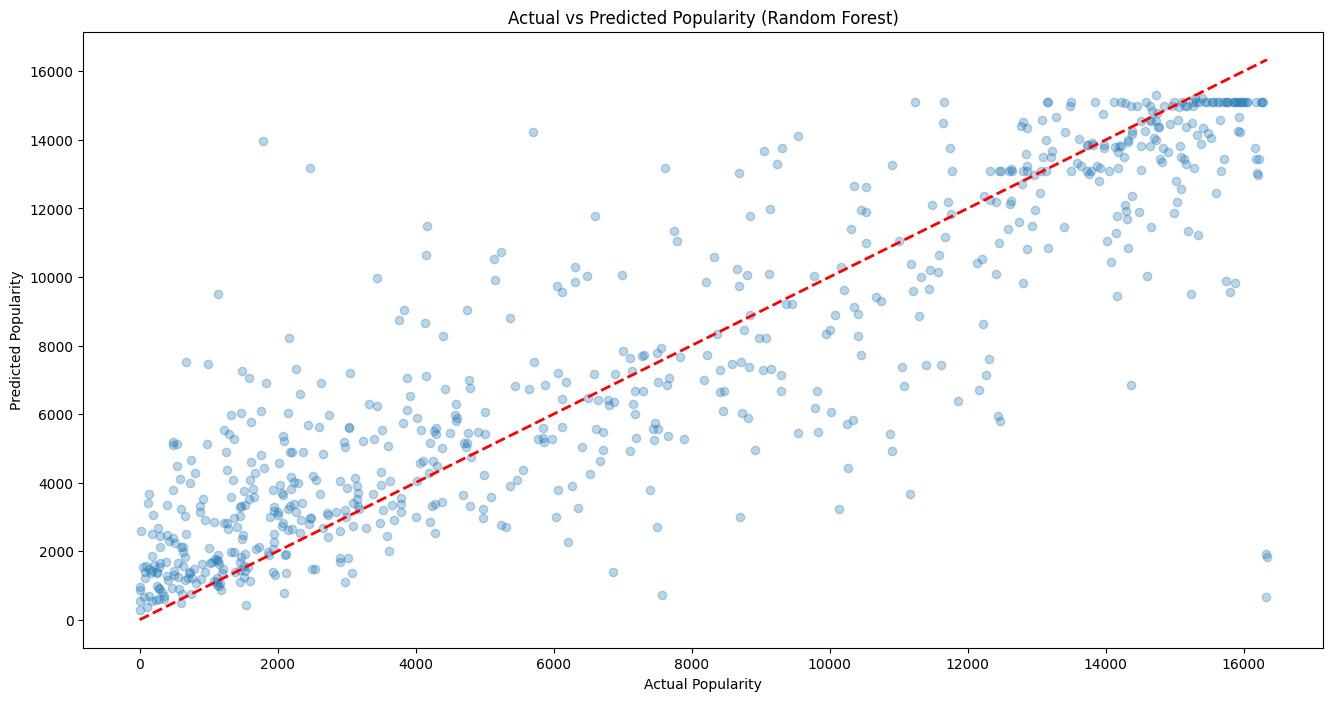

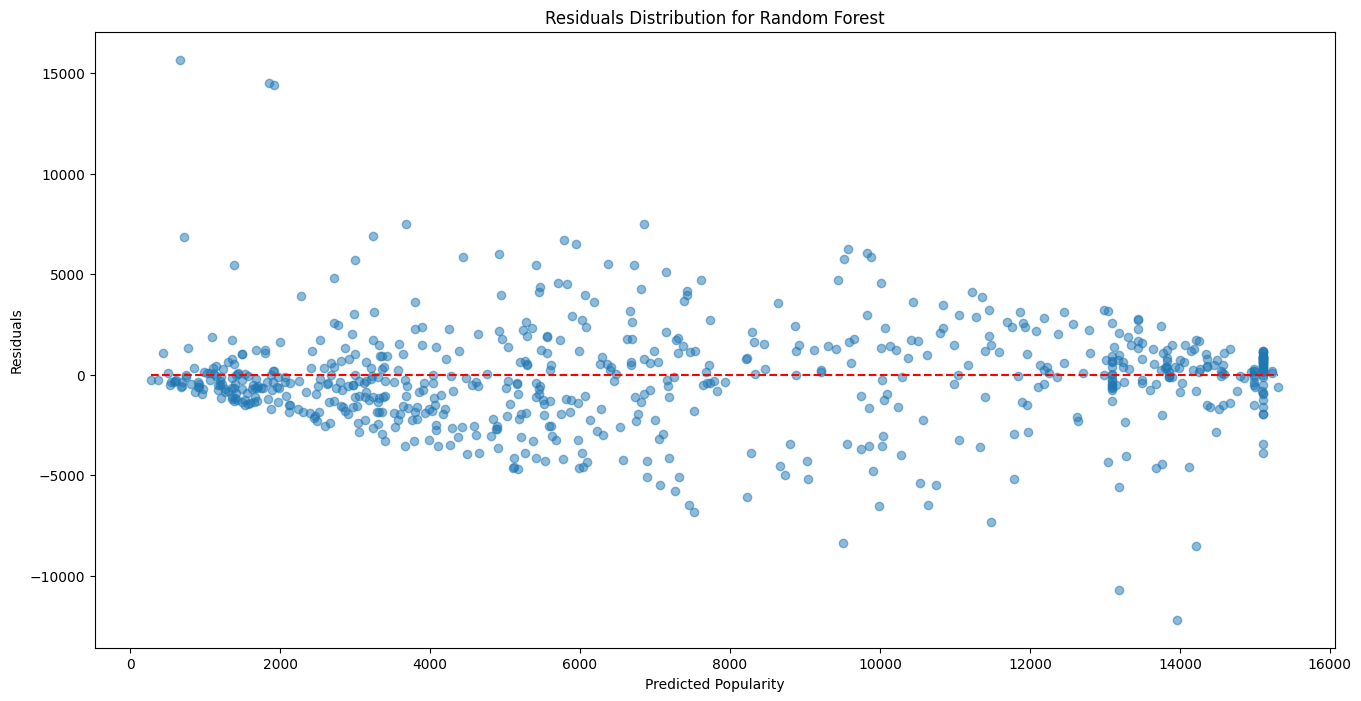

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity (Random Forest)')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(16, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Distribution for Random Forest')
plt.show()